In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as nu, pandas as pds, os, math, matplotlib.pyplot as matsp, seaborn as sbsp, nltk
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
from nltk import corpus    
from sklearn import neighbors, ensemble, linear_model, naive_bayes, neural_network,metrics, model_selection, utils
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.utils import resample
import datetime
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def SpamDataReading():
    ph=pds.read_csv("enron_spam_data.csv")
    if len(ph.columns)>2:
        ph=ph[['Message','Spam/Ham']]
    return ph
SpmData=SpamDataReading()
SpmData.head()

,Message,Spam/Ham
0,NaN,ham
1,"gary , production from the high island larger ...",ham
2,- calpine daily gas nomination 1 . doc,ham
3,fyi - see note below - already done .\nstella\...,ham
4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham


Spam/Ham
spam    17171
ham     16545
Name: count, dtype: int64


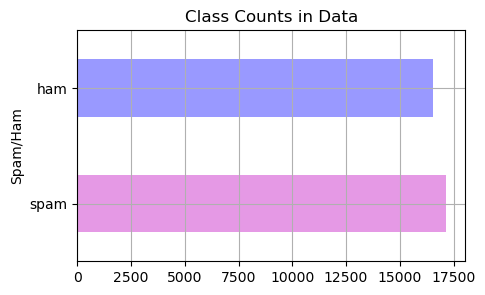

In [3]:
def EmailVIS(ph):
    trgvar='Spam/Ham'
    vctr=ph[trgvar].value_counts()
    print(vctr)
    vctr.plot(kind='barh',figsize=(5,3),title="Class Counts in Data",color=['m','b'],alpha=0.4)
    matsp.grid()
    matsp.show()
EmailVIS(SpmData)

In [4]:
def EmailFetDetails(sp):
    print("\nFeature Details Before Cleaning\n")
    print(sp.info(),"\n")
    mssp=sum(sp.isna().sum())
    if mssp>0:
        sp=sp.dropna() 
        print("\nFeature Details After Cleaning\n")
        print(sp.info(),"\n")
    return sp
    
SpmData=EmailFetDetails(SpmData)
SpmData.head()


Feature Details Before Cleaning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   33664 non-null  object
 1   Spam/Ham  33716 non-null  object
dtypes: object(2)
memory usage: 526.9+ KB
None 


Feature Details After Cleaning

<class 'pandas.core.frame.DataFrame'>
Index: 33664 entries, 1 to 33715
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   33664 non-null  object
 1   Spam/Ham  33664 non-null  object
dtypes: object(2)
memory usage: 789.0+ KB
None 



,Message,Spam/Ham
1,"gary , production from the high island larger ...",ham
2,- calpine daily gas nomination 1 . doc,ham
3,fyi - see note below - already done .\nstella\...,ham
4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham
5,"jackie ,\nsince the inlet to 3 river plant is ...",ham


In [5]:
xy="python coding".split()
' '.join(xy)

'python coding'

In [6]:
def TextCleanEmail(sp):
    SpStopsEm = list(corpus.stopwords.words('english'))
    SpCleaned=""
    for e in sp:
        if e.isalpha()==True:
            SpCleaned+=e
        if e.isalnum()==False:
            pass
        if e=="\n" or e==" " or e==":" or e==";" or e==",":
            SpCleaned+=" "
    SpSplit=SpCleaned.lower()
    TknSp=SpSplit.split()
    SpStopsEmCln=[]
    for i in TknSp:
        if i not in SpStopsEm:
            SpStopsEmCln.append(i)
    return ' '.join(SpStopsEmCln)

MsgSp=SpmData['Message'].tolist()
MsgCleaned=[]
for t in MsgSp:
    MsgCleaned.append(TextCleanEmail(t))
SpmData['Message']=MsgCleaned
SpmData.head()

,Message,Spam/Ham
1,gary production high island larger block comme...,ham
2,calpine daily gas nomination doc,ham
3,fyi see note already done stella forwarded ste...,ham
4,fyi forwarded lauri allen hou ect pm kimberly ...,ham
5,jackie since inlet river plant shut last day f...,ham


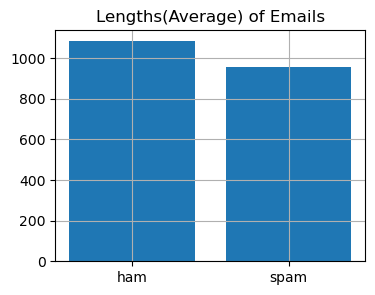

In [7]:
meanlngth=[]
SpCls=SpmData['Spam/Ham'].unique()
for x in SpCls:
    subdata=SpmData[SpmData['Spam/Ham']==x].reset_index(drop=True)
    lengths=[]
    for b in subdata['Message']:
        lengths.append(len(b))
    meanlngth.append(nu.mean(nu.array(lengths)))

matsp.figure(figsize=(4,3))
matsp.title("Lengths(Average) of Emails") 
matsp.bar(SpCls,meanlngth)
matsp.grid()
matsp.show()

In [8]:
SpmData1=SpmData.copy()
count_top=SpmData1['Spam/Ham'].value_counts().tolist()[0]
data_classes=SpmData1['Spam/Ham'].value_counts().index.tolist()

print("Class Labels Before Balancing\n")
print(SpmData1['Spam/Ham'].value_counts())

Data_EQSp=[]
for x in data_classes:
    df=SpmData1[SpmData1['Spam/Ham']==x]
    df=utils.resample(df, replace = True, n_samples = int(len(df)*(count_top/len(df))), random_state = 32)
    Data_EQSp.append(df)
SpmData1_EQ=pds.concat(Data_EQSp).reset_index(drop=True)
SpmData1_EQ1=utils.resample(SpmData1_EQ, replace = True, n_samples = int(len(SpmData1_EQ)*2), random_state = 32)

print("\nClass Labels After Balancing\n")
print(SpmData1_EQ1['Spam/Ham'].value_counts())

SpDtTrPart=SpmData1_EQ1.iloc[0:int(SpmData1_EQ1.shape[0]*0.75)]
SpDtTsPart=SpmData1_EQ1.iloc[int(SpmData1_EQ1.shape[0]*0.75):]
print(SpDtTrPart.shape,SpDtTsPart.shape)
print("\nTraining Class Distribution\n",SpDtTrPart['Spam/Ham'].value_counts())
print("\nTest Class Distribution\n",SpDtTsPart['Spam/Ham'].value_counts())

Class Labels Before Balancing

Spam/Ham
spam    17171
ham     16493
Name: count, dtype: int64

Class Labels After Balancing

Spam/Ham
ham     34363
spam    34321
Name: count, dtype: int64
(51513, 2) (17171, 2)

Training Class Distribution
 Spam/Ham
ham     25787
spam    25726
Name: count, dtype: int64

Test Class Distribution
 Spam/Ham
spam    8595
ham     8576
Name: count, dtype: int64


In [10]:
txt_SpDtTrPart=SpDtTrPart['Message']
txt_SpDtTsPart=SpDtTsPart['Message']
ClsTest=SpDtTsPart['Message']
ClsTrain=SpDtTrPart['Spam/Ham']
CVFetUni=CountVectorizer(stop_words='english', analyzer='word',max_df=0.6,ngram_range=(1,1))
TrnVctUniCV=CVFetUni.fit_transform(txt_SpDtTrPart) 
TstVctUniCV=CVFetUni.transform(txt_SpDtTsPart)

CVFetBi=CountVectorizer(stop_words='english', analyzer='word',max_df=0.6,ngram_range=(2,2))
TrnVctBiCV=CVFetBi.fit_transform(txt_SpDtTrPart) 
TstVctBiCV=CVFetBi.transform(txt_SpDtTsPart)

print("Feature Extracted Using CV and {}:".format("UniGram"),TrnVctUniCV.shape[1])
print("Feature Extracted Using CV and {}:".format("BiGram"),TrnVctBiCV.shape[1])

Feature Extracted Using CV and UniGram: 40006
Feature Extracted Using CV and BiGram: 575070


In [11]:
TFIDFFetUni=TfidfVectorizer(stop_words='english', analyzer='word',max_df=0.6,ngram_range=(1,1))
TrnVctUniTF=TFIDFFetUni.fit_transform(txt_SpDtTrPart) 
TstVctUniTF=TFIDFFetUni.transform(txt_SpDtTsPart)

TFIDFFetBi=TfidfVectorizer(stop_words='english', analyzer='word',max_df=0.6,ngram_range=(2,2))
TrnVctBiTF=TFIDFFetBi.fit_transform(txt_SpDtTrPart) 
TstVctBiTF=TFIDFFetBi.transform(txt_SpDtTsPart)

print("Feature Extracted Using CV and {}:".format("UniGram"),TrnVctUniTF.shape[1])
print("Feature Extracted Using CV and {}:".format("BiGram"),TrnVctBiTF.shape[1])

Feature Extracted Using CV and UniGram: 40006
Feature Extracted Using CV and BiGram: 575070
